# Gestão da Volatilidade em um Portfolio de Criptomoedas

Confira o estudo nos posts:

Parte 1: https://ruan-lima.medium.com/gest%C3%A3o-da-volatilidade-em-um-portfolio-de-criptomoedas-parte-1-f6af3029bddb

Parte 2: https://ruan-lima.medium.com/gest%C3%A3o-da-volatilidade-em-um-portfolio-de-criptomoedas-parte-2-398cf0151b35


## Bibliotecas

In [48]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
import rpsl_portfolio_calcs as rpsl

## Preços/Cotações

In [49]:
price_d = pd.read_csv('preco_d.csv')
price_d = price_d.rename(columns={'Unnamed: 0': 'Date'})
price_d.index = pd.to_datetime(price_d.Date)
del price_d['Date']

inds_comparrison = pd.read_csv('ativos_comparacao.csv')
inds_comparrison = inds_comparrison.rename(columns={'Unnamed: 0': 'Date'})
inds_comparrison.index = pd.to_datetime(inds_comparrison.Date)
del inds_comparrison['Date']

In [50]:
price_m = price_d.resample('BMS').first()
r_m = price_m.pct_change()
r_m.index = pd.to_datetime(r_m.index, format="%Y%m").to_period('M')

inds_comparrison_m = inds_comparrison.resample('BMS').first()
ret_inds_comparrison_m = inds_comparrison_m.pct_change()
ret_inds_comparrison_m.index = pd.to_datetime(ret_inds_comparrison_m.index, format="%Y%m").to_period('M')

## Estudo

Quando estamos naquela conversa no nosso grupo de amigos e surge o assunto de Criptomoedas, Bitcoins, Ethereum, etc...
sempre surge a questão da volatilidade.
No gráfico abaixo, quando colocamos o IBOV e o Bitcoin em sobreposição não parecem tão diferentes
mas quando analisados os retornos percentuais, conseguimos ver claramente essa maior volatilidade do bitcoin.

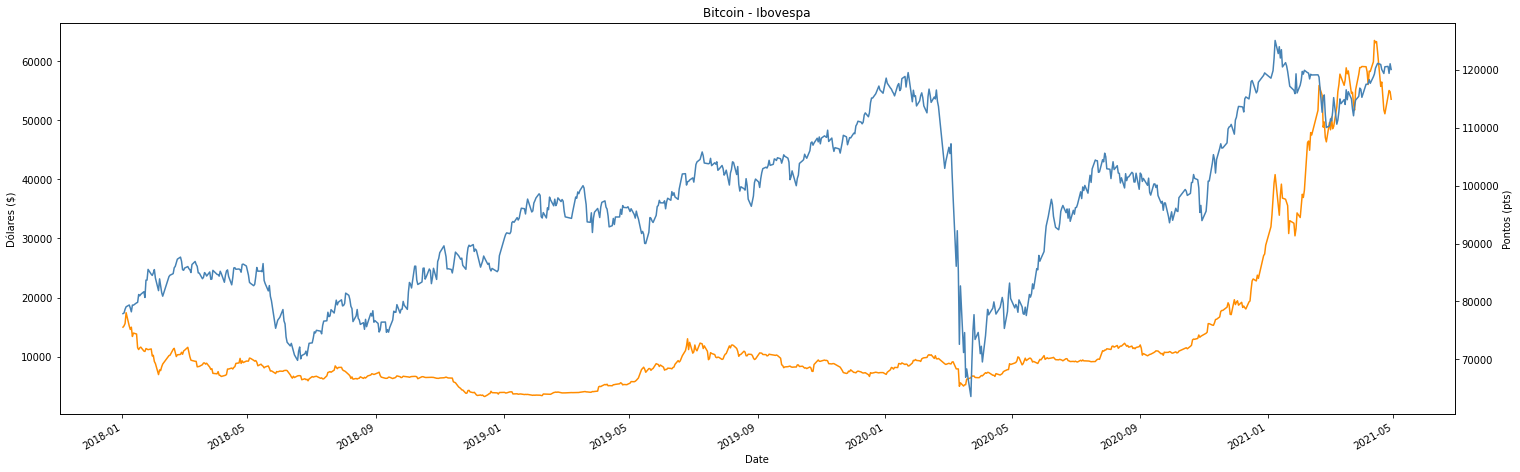

In [51]:
ibov_bitcoin = pd.DataFrame(
    {
        'Bitcoin':price_d['BTC-USD'],
        'Ibov':inds_comparrison['^BVSP'],
        'Dogecoin':price_d['DOGE-USD']
    }
)
ibov_bitcoin = ibov_bitcoin.dropna()
ax = ibov_bitcoin['Bitcoin']["2018":].plot(figsize=(25,8), title="Bitcoin - Ibovespa", style='darkorange')
ibov_bitcoin['Ibov']["2018":].plot(secondary_y=True, style='steelblue', label='Ibov')
ax.set_ylabel('Dólares ($)')
ax.right_ax.set_ylabel('Pontos (pts)');

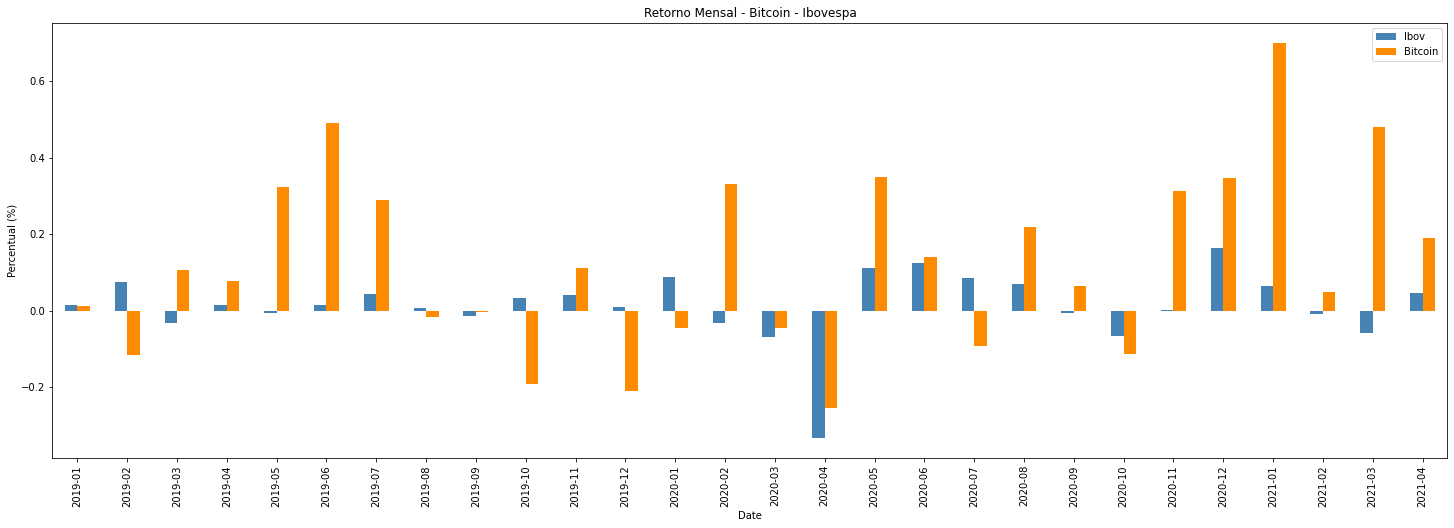

In [52]:
#Gráfico Retorno IBOV e Bitcoin
ibov_bitcoin_m = ibov_bitcoin.resample("BMS").first()
r_ibov_bitcoin_m = ibov_bitcoin_m.pct_change()
r_ibov_bitcoin_m.index = pd.to_datetime(r_ibov_bitcoin_m.index, format="%Y%m").to_period('M')
ax = r_ibov_bitcoin_m[['Ibov', 'Bitcoin']]["2019":].plot.bar(figsize=(25, 8), title="Retorno Mensal - Bitcoin - Ibovespa", color=['steelblue', 'darkorange'])
ax.set_ylabel('Percentual (%)');

A volatilidade se mostra ainda maior quando comparamos o bitcoin com outras criptos como o Dogecoin

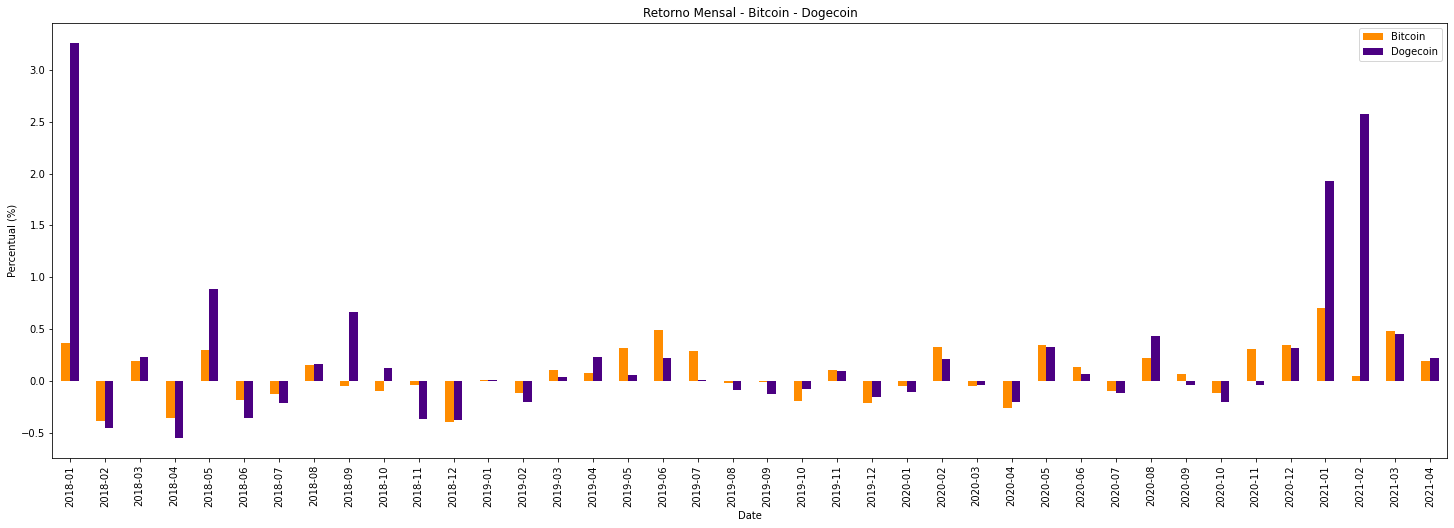

In [53]:
ax = r_ibov_bitcoin_m[['Bitcoin', 'Dogecoin']]["2018":].plot.bar(figsize=(25, 8), title="Retorno Mensal - Bitcoin - Dogecoin", color=['darkorange', 'indigo']);
ax.set_ylabel('Percentual (%)');

Qual meu risco para um portfolio com 100% de alocação somente em Dogecoin desde 2015 por exemplo?

In [54]:
std_dogecoin = r_ibov_bitcoin_m['Dogecoin']["2015":].std()
print('Com essa divisão o risco da carteira seria: '+str(np.round(std_dogecoin*100,2))+'%')

Com essa divisão o risco da carteira seria: 72.64%


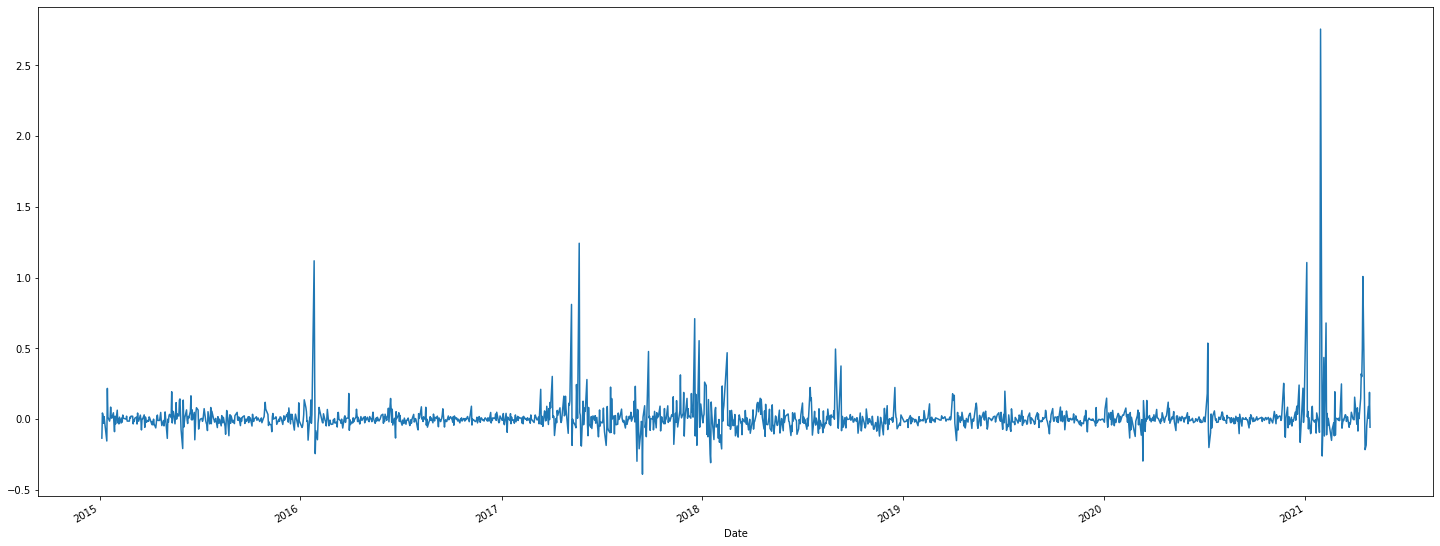

In [55]:
ibov_bitcoin['Dogecoin']["2015":].pct_change().plot(figsize=(25, 10), subplots=True);


E se alocássemos pesos iguais para cada um dos ativos?

Considerando 30 ativos
dividindo igualmente os pesos de cada um
teríamos um peso de: 3.33% para cada



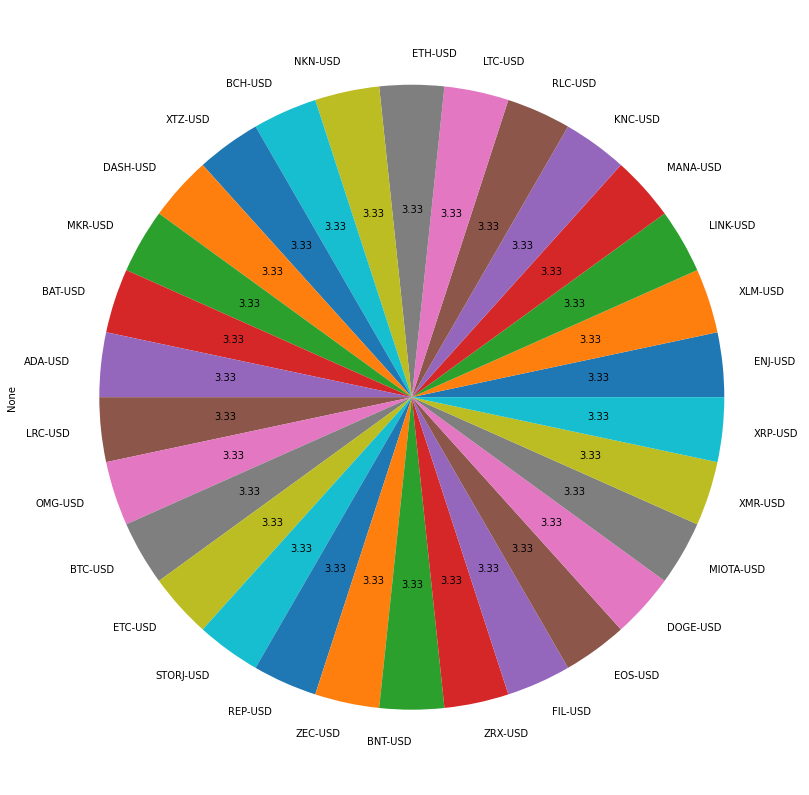

In [56]:
# Pesos iguais por número de ativos
t_ew = rpsl.weight_ew(r_m)
t_ew.plot.pie(subplots=True, figsize=(14, 16), autopct="%.2f",fontsize=10)
print('Considerando '+str(r_m.shape[1])+
      ' ativos\ndividindo igualmente os pesos de cada um\nteríamos um peso de: '+str(np.round(t_ew[0]*100,2))+
      '% para cada\n')

In [57]:
risk_t_ew = rpsl.portfolio_vol(t_ew, rpsl.sample_cov(r_m))
print('Com essa divisão o risco da carteira seria: '+str(np.round(risk_t_ew*100,2))+'%')

Com essa divisão o risco da carteira seria: 52.21%


In [58]:
"""
# A volatilidade anualizada seria:
pd.DataFrame(
    {
        "2019" : np.round(rpsl.annualize_vol(r_m["2019":"2019"], 12),2)*100,
        "2020" : np.round(rpsl.annualize_vol(r_m["2020":"2020"], 12),2)*100,
        "2021" : np.round(rpsl.annualize_vol(r_m["2021":"2021"], 12),2)*100
    }
    ).plot.barh(figsize=(25, 12), subplots=False);
"""

'\n# A volatilidade anualizada seria:\npd.DataFrame(\n    {\n        "2019" : np.round(rpsl.annualize_vol(r_m["2019":"2019"], 12),2)*100,\n        "2020" : np.round(rpsl.annualize_vol(r_m["2020":"2020"], 12),2)*100,\n        "2021" : np.round(rpsl.annualize_vol(r_m["2021":"2021"], 12),2)*100\n    }\n    ).plot.barh(figsize=(25, 12), subplots=False);\n'

A contribuição de cada ativo para este risco no portfolio seria de:

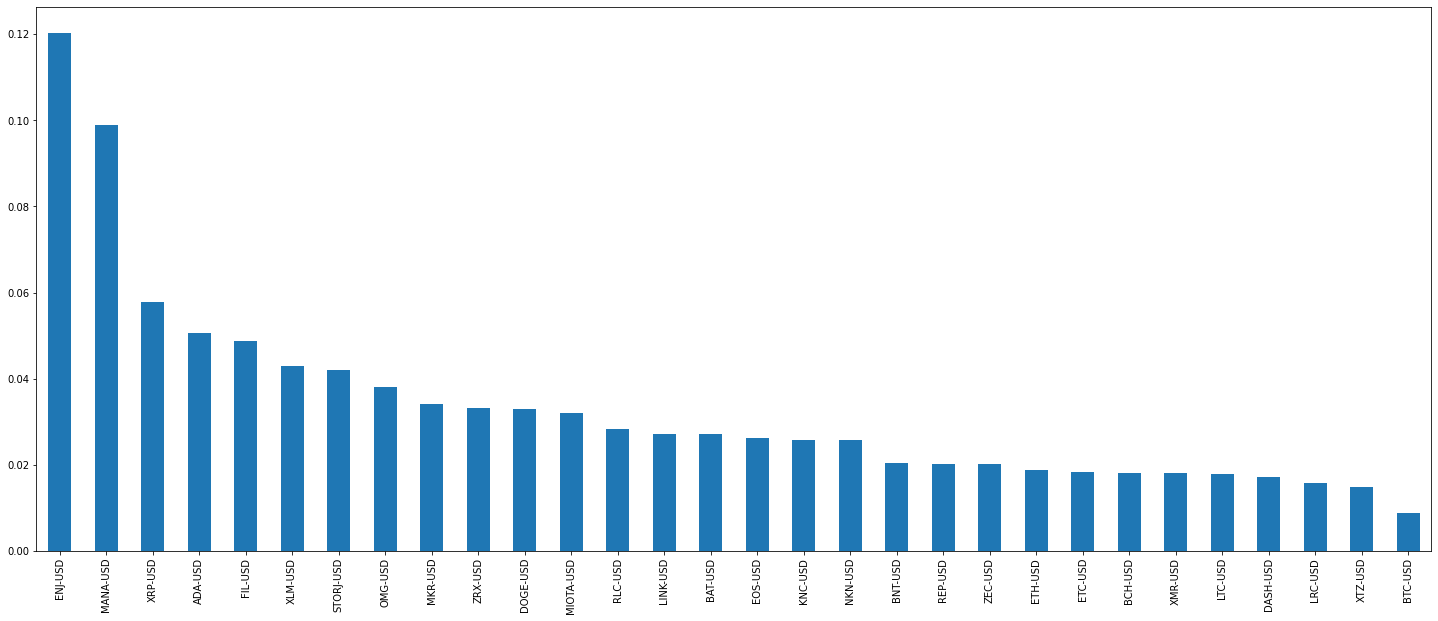

In [59]:
contrib_unit_t_ew = rpsl.risk_contribution(t_ew,rpsl.sample_cov(r_m)).sort_values(ascending=False)
contrib_unit_t_ew.plot.bar(figsize=(25, 10), subplots=False);

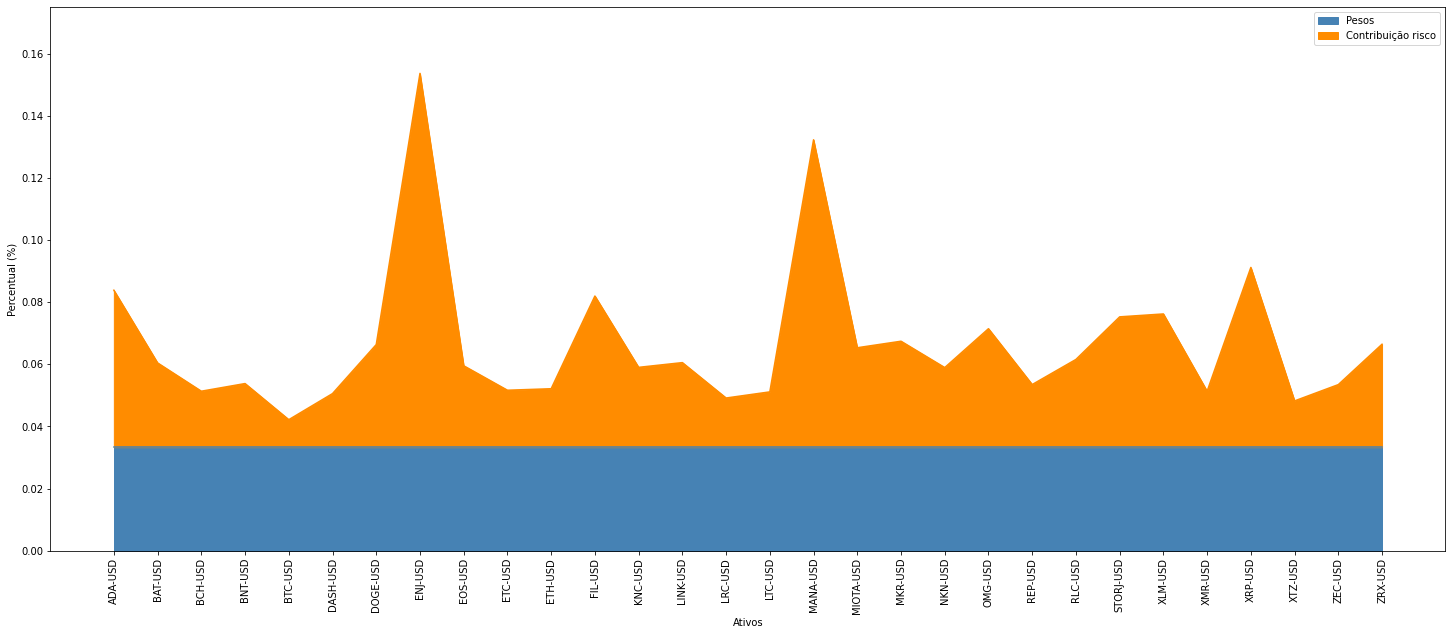

In [41]:
df_ew1 = pd.DataFrame({
    'Pesos': t_ew,
    'Contribuição risco': contrib_unit_t_ew,
    'Ativos': contrib_unit_t_ew.index
})
ax = df_ew1.plot.area(x='Ativos', figsize=(25, 10), color=['steelblue', 'darkorange'])
ax.set_xticks(range(0,t_ew.shape[0]))
ax.set_xticklabels(df_ew1.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0,.175)
ax.set_ylabel('Percentual (%)');
ax.axhline(risk_t_ew);

E se quisessemos a relação contrária, quais os pesos dos ativos no caso de risco igual entre eles?

Risco dividido igualmente entre os 30 ativos
Um risco de aproximadamente: 3.33% para cada ativo


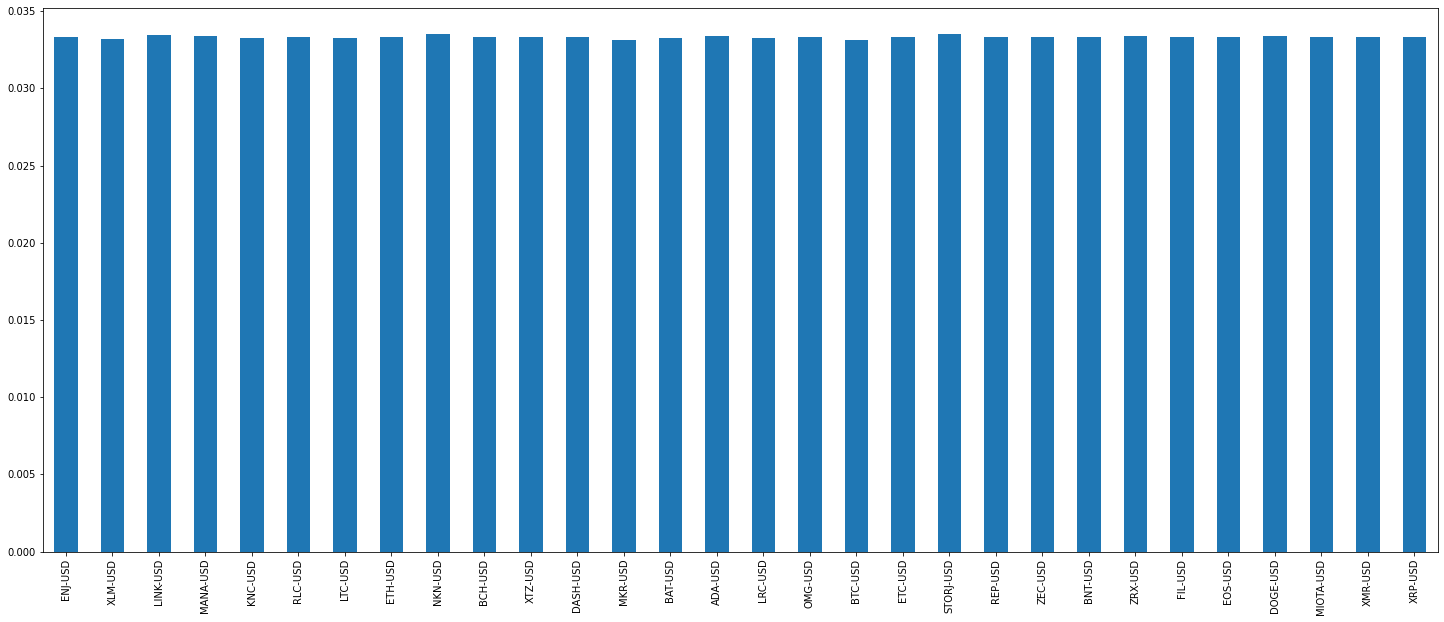

In [60]:
t_erw = rpsl.equal_risk_contributions(rpsl.sample_cov(r_m))
contrib_unit_t_erw = np.round(rpsl.risk_contribution(t_erw, rpsl.sample_cov(r_m)),6)
print('Risco dividido igualmente entre os '+str(r_m.shape[1])+' ativos')
print('Um risco de aproximadamente: '+str(np.round(t_ew[0]*100,2))+'% para cada ativo')
contrib_unit_t_erw.plot.bar(figsize=(25, 10), subplots=False);

Teríamos os pesos entre os 30 ativos divididos desta forma:



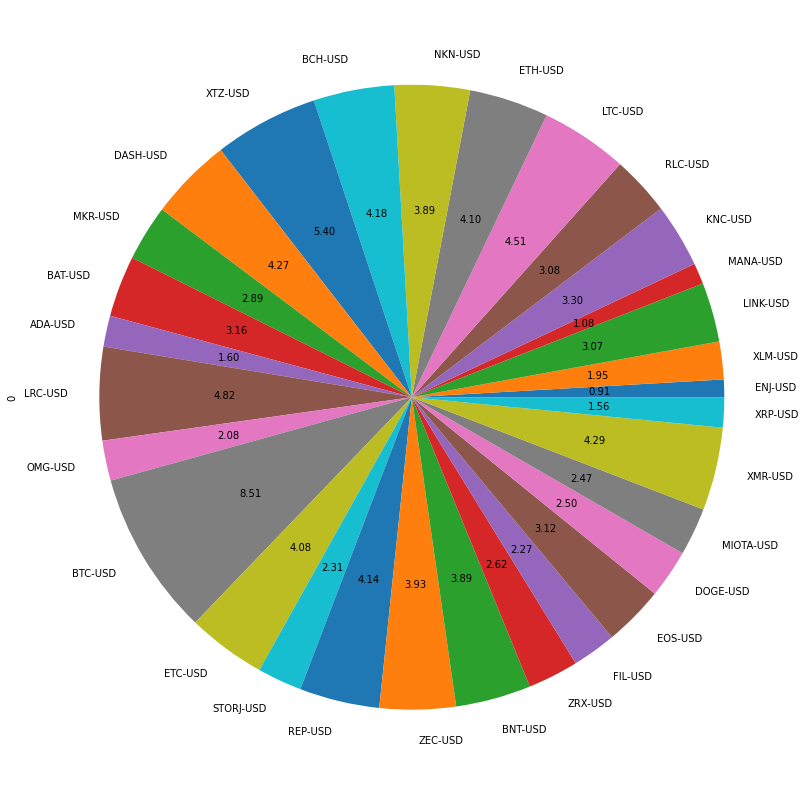

In [61]:
df_t_erw = pd.DataFrame(t_erw, index=t_ew.index)
df_t_erw.plot.pie(subplots=True, figsize=(14, 16), legend=False, autopct="%.2f",fontsize=10)
print('Teríamos os pesos entre os '+str(r_m.shape[1])+' ativos divididos desta forma:\n')

Repare na força do bitcoin, com o maior peso atribuído para gestão deste risco

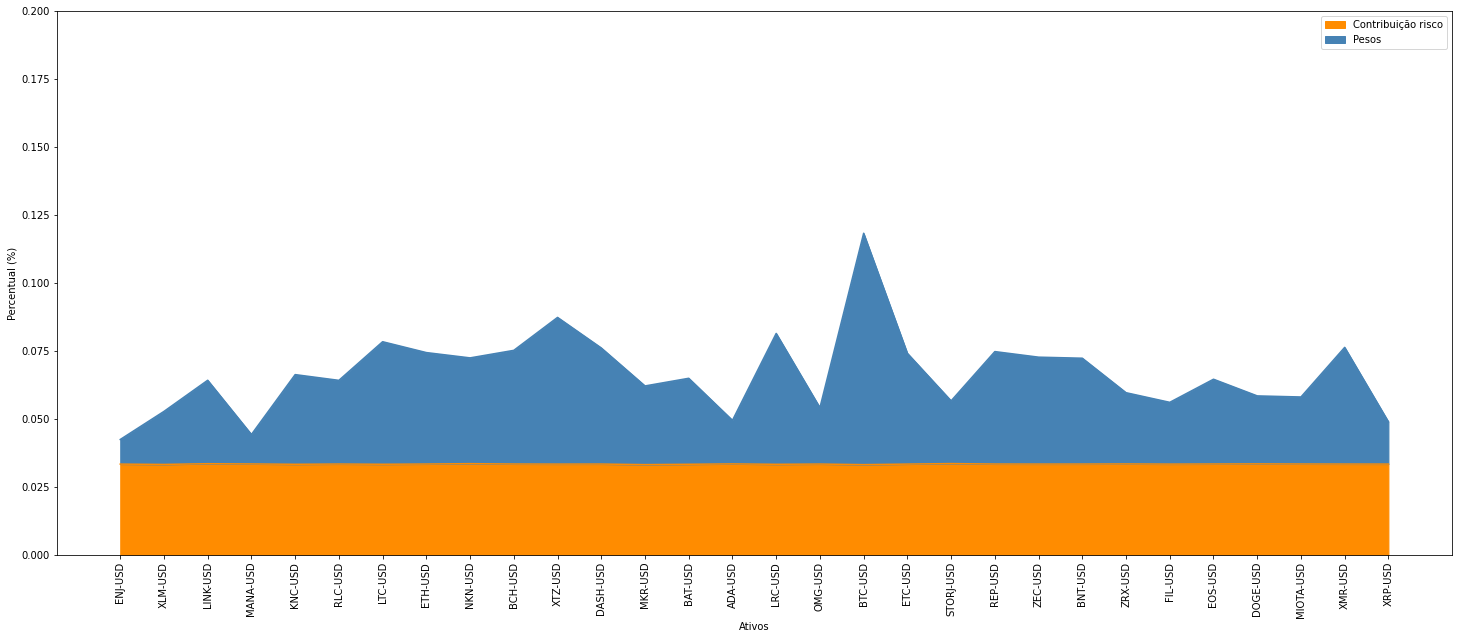

In [63]:
risk_t_erw = rpsl.portfolio_vol(t_erw, rpsl.sample_cov(r_m))
df_erw = pd.DataFrame({
    'Contribuição risco': contrib_unit_t_erw,
    'Pesos': t_erw,
    'Ativos': contrib_unit_t_erw.index
})
ax = df_erw.plot.area(x='Ativos', figsize=(25, 10), color=['darkorange', 'steelblue'])#, stacked=False)
ax.set_xticks(range(0,contrib_unit_t_erw.shape[0]))
ax.set_xticklabels(df_erw.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0,.2)
ax.set_ylabel('Percentual (%)')
ax.axhline(risk_t_erw);

In [64]:
#Com essa divisão o risco da carteira seria:
risk_t_erw = rpsl.portfolio_vol(t_erw, rpsl.sample_cov(r_m))
print('Com essa divisão o risco da carteira seria: '+str(np.round(risk_t_erw*100,2))+'%')

Com essa divisão o risco da carteira seria: 40.97%
